In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import UpSampling2D, Conv2D, MaxPooling2D, Activation, BatchNormalization
import numpy as np
import glob
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from livelossplot.keras import PlotLossesCallback

Using TensorFlow backend.


In [2]:
input_n=128

In [38]:
def keras_generator(gen_df, batch_size, input_n):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_name = gen_df.sample(1).values[0]
            try:
                img=np.load(img_name).reshape(input_n,input_n,3)
                mask=np.load(mask_name).reshape(input_n,input_n,1)
            except:
                i-=1

            x_batch += [img]
            y_batch += [mask]
        
        x_batch = np.array(x_batch)/ 255.
        y_batch = np.array(y_batch)

        yield x_batch, y_batch 

In [26]:
def construct_unet(input_n):
    inp = Input(shape=(input_n,input_n, 3))

    conv_1_1 = Conv2D(32, 3, padding='same')(inp)
    conv_1_1 = BatchNormalization(axis=3)(conv_1_1)
    conv_1_1 = Activation('relu')(conv_1_1)

    conv_1_2 = Conv2D(32, 3, padding='same')(conv_1_1)
    conv_1_2 = BatchNormalization(axis=3)(conv_1_2)
    conv_1_2 = Activation('relu')(conv_1_2)

    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, 3, padding='same')(pool_1)
    conv_2_1 = BatchNormalization(axis=3)(conv_2_1)
    conv_2_1 = Activation('relu')(conv_2_1)

    conv_2_2 = Conv2D(64, 3, padding='same')(conv_2_1)
    conv_2_2 = BatchNormalization(axis=3)(conv_2_2)
    conv_2_2 = Activation('relu')(conv_2_2)

    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, 3, padding='same')(pool_2)
    conv_3_1 = BatchNormalization(axis=3)(conv_3_1)
    conv_3_1 = Activation('relu')(conv_3_1)

    conv_3_2 = Conv2D(128, 3, padding='same')(conv_3_1)
    conv_3_2 = BatchNormalization(axis=3)(conv_3_2)
    conv_3_2 = Activation('relu')(conv_3_2)

    pool_3 = MaxPooling2D(2)(conv_3_2)


    conv_4_1 = Conv2D(256, 3, padding='same')(pool_3)
    conv_4_1 = BatchNormalization(axis=3)(conv_4_1)
    conv_4_1 = Activation('relu')(conv_4_1)

    conv_4_2 = Conv2D(256, 3, padding='same')(conv_4_1)
    conv_4_2 = BatchNormalization(axis=3)(conv_4_2)
    conv_4_2 = Activation('relu')(conv_4_2)

    pool_4 = MaxPooling2D(2)(conv_4_2)

    up_1 = UpSampling2D(2,interpolation='bilinear')(pool_4)
    conc_1 = Concatenate()([conv_4_2, up_1])

    conv_up_1_1 = Conv2D(256, 3, padding='same')(conc_1)
    conv_up_1_1 = BatchNormalization(axis=3)(conv_up_1_1)
    conv_up_1_1 = Activation('relu')(conv_up_1_1)

    conv_up_1_2 = Conv2D(256, 3, padding='same')(conv_up_1_1)
    conv_up_1_2 = BatchNormalization(axis=3)(conv_up_1_2)
    conv_up_1_2 = Activation('relu')(conv_up_1_2)

    up_2 = UpSampling2D(2,interpolation='bilinear')(conv_up_1_2)
    conc_2 = Concatenate()([conv_3_2, up_2])

    conv_up_2_1 = Conv2D(128, 3, padding='same')(conc_2)
    conv_up_2_1 = BatchNormalization(axis=3)(conv_up_2_1)
    conv_up_2_1 = Activation('relu')(conv_up_2_1)

    conv_up_2_2 = Conv2D(128, 3, padding='same')(conv_up_2_1)
    conv_up_2_2 = BatchNormalization(axis=3)(conv_up_2_2)
    conv_up_2_2 = Activation('relu')(conv_up_2_2)

    up_3 = UpSampling2D(2,interpolation='bilinear')(conv_up_2_2)
    conc_3 = Concatenate()([conv_2_2, up_3])

    conv_up_3_1 = Conv2D(64, 3, padding='same')(conc_3)
    conv_up_3_1 = BatchNormalization(axis=3)(conv_up_3_1)
    conv_up_3_1 = Activation('relu')(conv_up_3_1)

    conv_up_3_2 = Conv2D(64, 3, padding='same')(conv_up_3_1)
    conv_up_3_2 = BatchNormalization(axis=3)(conv_up_3_2)
    conv_up_3_2 = Activation('relu')(conv_up_3_2)

    up_4 = UpSampling2D(2,interpolation='bilinear')(conv_up_3_2)
    conc_4 = Concatenate()([conv_1_2, up_4])
    conv_up_4_1 = Conv2D(32, 3, padding='same')(conc_4)
    conv_up_4_1 = BatchNormalization(axis=3)(conv_up_4_1)
    conv_up_4_1 = Activation('relu')(conv_up_4_1)
    
    conv_up_4_2 = Conv2D(32, 3, padding='same')(conv_up_4_1)
    conv_up_4_2 = BatchNormalization(axis=3)(conv_up_4_2)
    conv_up_4_2 = Activation('relu')(conv_up_4_2)

    conv_up_4_2 = Conv2D(1, 3, padding='same')(conv_up_4_1)
    result = Activation('sigmoid')(conv_up_4_2)

    model = Model(inputs=inp, outputs=result)
    
    return model

In [27]:
model=construct_unet(input_n)

In [28]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 128, 128, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 128, 128, 32) 128         conv2d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 128, 128, 32) 0           batch_normalization_17[0][0]     
____________________________________________________________________________________________

In [29]:
original_imgs = glob.glob(os.path.join('/IMAGE_DIR', '*.npy'))
masks = glob.glob(os.path.join('/MASK_DIR', '*.npy'))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(original_imgs, masks, test_size=0.1, random_state=42)

In [31]:
input_frame=pd.DataFrame(X_train)
input_frame['1']=y_train

In [33]:
val_frame=pd.DataFrame(X_test)
val_frame['1']=y_test

In [ ]:
# run to test generator
for x,y in keras_generator(input_frame, 16, input_n):
    break

In [36]:

best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(adam, 'binary_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]) 

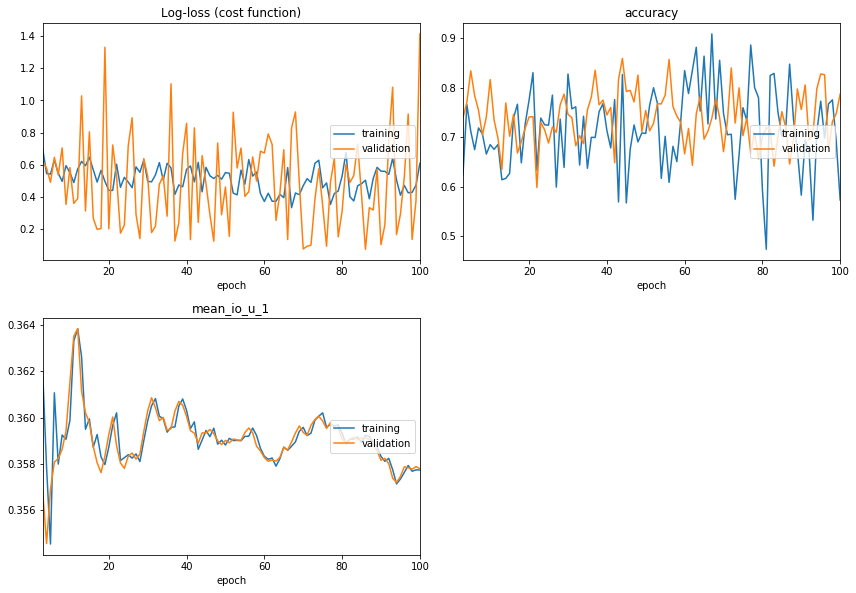

Log-loss (cost function):
training   (min:    0.334, max:    0.698, cur:    0.609)
validation (min:    0.075, max:    1.414, cur:    1.414)

accuracy:
training   (min:    0.474, max:    0.909, cur:    0.573)
validation (min:    0.599, max:    0.860, cur:    0.788)

mean_io_u_1:
training   (min:    0.355, max:    0.369, cur:    0.358)
validation (min:    0.355, max:    0.364, cur:    0.358)


In [39]:
batch_size = 2
model.fit_generator(keras_generator(input_frame, batch_size, input_n),
              steps_per_epoch=10,
              epochs=100,
              callbacks=[PlotLossesCallback()],
              validation_data=keras_generator(val_frame, batch_size, input_n),
              validation_steps=50,
              use_multiprocessing=True,
              initial_epoch=0)

In [ ]:
model.save('model.h')